In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install --upgrade tensorflow==2.10.0

In [2]:
!unzip -q /content/set.zip

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
# Load pre-trained ResNet50 model (excluding top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(254, 254, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
inputs = layers.Input(shape=(254, 254, 3))
x = base_model(inputs, training=False) # Pass inputs through ResNet50
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x)  # Add a dense layer
x = layers.Dropout(0.3)(x)  # Add a dropout layer
predictions = layers.Dense(10, activation="softmax")(x)  # Output layer

# Combine base model and new layers
combined_model = Model(inputs=inputs, outputs=predictions)

# Compile the model
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 1s 0us/step


In [5]:
combined_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 254, 254, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                             

In [6]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds = image_dataset_from_directory(
  '/content/set/train',
  labels = "inferred",
  label_mode = "categorical",
  seed=123,
  image_size=(254, 254),
  batch_size=128)

val_ds = image_dataset_from_directory(
  '/content/set/val',
  labels = "inferred",
  label_mode = "categorical",
  seed=123,
  image_size=(254, 254),
  batch_size=128)

Found 6307 files belonging to 10 classes.
Found 1108 files belonging to 10 classes.


In [7]:
# prompt: normalize pictures from train_ds and val_ds by 255

normalized_train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))


In [8]:
class_names = train_ds.class_names
print(class_names)

['Aluminium', 'Closhoes', 'DrinkCans', 'Glass', 'GlassBottles', 'Organic', 'Paperboard', 'Piles', 'Plastic', 'PlasticBottles']


In [9]:
class_val_names = val_ds.class_names
print(class_val_names)

['Aluminium', 'Closhoes', 'DrinkCans', 'Glass', 'GlassBottles', 'Organic', 'Paperboard', 'Piles', 'Plastic', 'PlasticBottles']


In [10]:
LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=2, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, restore_best_weights=True)

In [11]:
%%time

history = combined_model.fit(
        normalized_train_ds,
        epochs=30,
        validation_data=normalized_val_ds,
        callbacks = [LRreducer, EarlyStopper])

Epoch 1/30
50/50 [==============================] - 184s 4s/step - loss: 0.6049 - accuracy: 0.8145 - val_loss: 0.3034 - val_accuracy: 0.9016 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 179s 4s/step - loss: 0.1967 - accuracy: 0.9307 - val_loss: 0.3355 - val_accuracy: 0.8899 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 178s 3s/step - loss: 0.1376 - accuracy: 0.9539 - val_loss: 0.2535 - val_accuracy: 0.9161 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 177s 3s/step - loss: 0.0945 - accuracy: 0.9694 - val_loss: 0.2308 - val_accuracy: 0.9242 - lr: 0.0010
Epoch 5/30
50/50 [==============================] - 177s 3s/step - loss: 0.0563 - accuracy: 0.9841 - val_loss: 0.2837 - val_accuracy: 0.9088 - lr: 0.0010
Epoch 6/30
50/50 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9848
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
50/50 [==============================] - 178s 4s/step - los

In [12]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

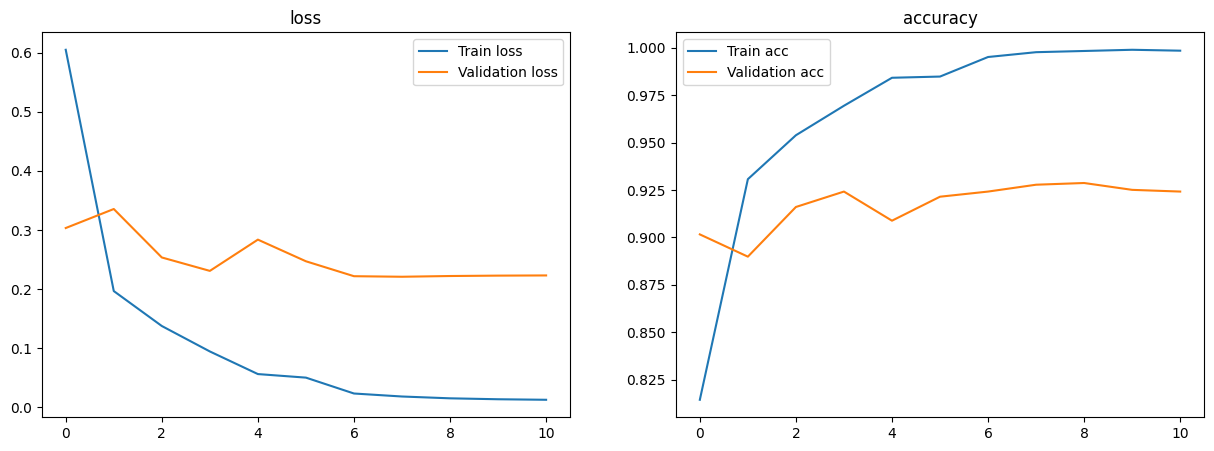

In [13]:
plot_history(history)

In [14]:
combined_model.save('/content/model_v10.h5')

In [15]:
# prompt: make a test_ds from content/subset/test and then predict for each picture the label with combined_model and compare to the true label, show also accuracy

import numpy as np

test_ds = image_dataset_from_directory(
  '/content/set/test',
  labels = "inferred",
  label_mode = "categorical",
  seed=123,
  image_size=(254, 254),
  batch_size=128,
  shuffle=False # Important to keep the order for comparison
)

normalized_test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

# Predict on test set
predictions = combined_model.predict(normalized_test_ds)

# Get true labels
y_true = []
for images, labels in test_ds:
  y_true.extend(np.argmax(labels, axis=1))

# Get predicted labels
y_pred = np.argmax(predictions, axis=1)

# Compare predictions to true labels
correct = 0
for i in range(len(y_true)):
  print(f"Image {i+1}: Predicted: {class_names[y_pred[i]]}, True: {class_names[y_true[i]]}")
  if y_pred[i] == y_true[i]:
    correct += 1

# Calculate accuracy
accuracy = correct / len(y_true)
print(f"\nAccuracy: {accuracy * 100:.2f}%")


Found 387 files belonging to 10 classes.
4/4 [==============================] - 10s 2s/step
Image 1: Predicted: Aluminium, True: Aluminium
Image 2: Predicted: Aluminium, True: Aluminium
Image 3: Predicted: Aluminium, True: Aluminium
Image 4: Predicted: Aluminium, True: Aluminium
Image 5: Predicted: Aluminium, True: Aluminium
Image 6: Predicted: Aluminium, True: Aluminium
Image 7: Predicted: Aluminium, True: Aluminium
Image 8: Predicted: Plastic, True: Aluminium
Image 9: Predicted: Aluminium, True: Aluminium
Image 10: Predicted: Aluminium, True: Aluminium
Image 11: Predicted: Aluminium, True: Aluminium
Image 12: Predicted: Aluminium, True: Aluminium
Image 13: Predicted: Aluminium, True: Aluminium
Image 14: Predicted: Aluminium, True: Aluminium
Image 15: Predicted: Aluminium, True: Aluminium
Image 16: Predicted: Aluminium, True: Aluminium
Image 17: Predicted: PlasticBottles, True: Aluminium
Image 18: Predicted: Plastic, True: Aluminium
Image 19: Predicted: Aluminium, True: Aluminium
Imag

In [16]:
# prompt: show accuracy class by class

from sklearn.metrics import classification_report

# Assuming 'class_names' is defined as in your provided code
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


                precision    recall  f1-score   support

     Aluminium       0.94      0.92      0.93        48
      Closhoes       0.98      1.00      0.99        41
     DrinkCans       1.00      0.93      0.96        28
         Glass       0.94      0.91      0.92        33
  GlassBottles       0.95      0.93      0.94        43
       Organic       0.94      1.00      0.97        47
    Paperboard       0.97      0.90      0.94        42
         Piles       0.97      1.00      0.99        39
       Plastic       0.81      0.86      0.83        29
PlasticBottles       0.87      0.89      0.88        37

      accuracy                           0.94       387
     macro avg       0.94      0.93      0.93       387
  weighted avg       0.94      0.94      0.94       387



<ipython-input-21-ade92997d534>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=class_accuracy, palette="pastel")


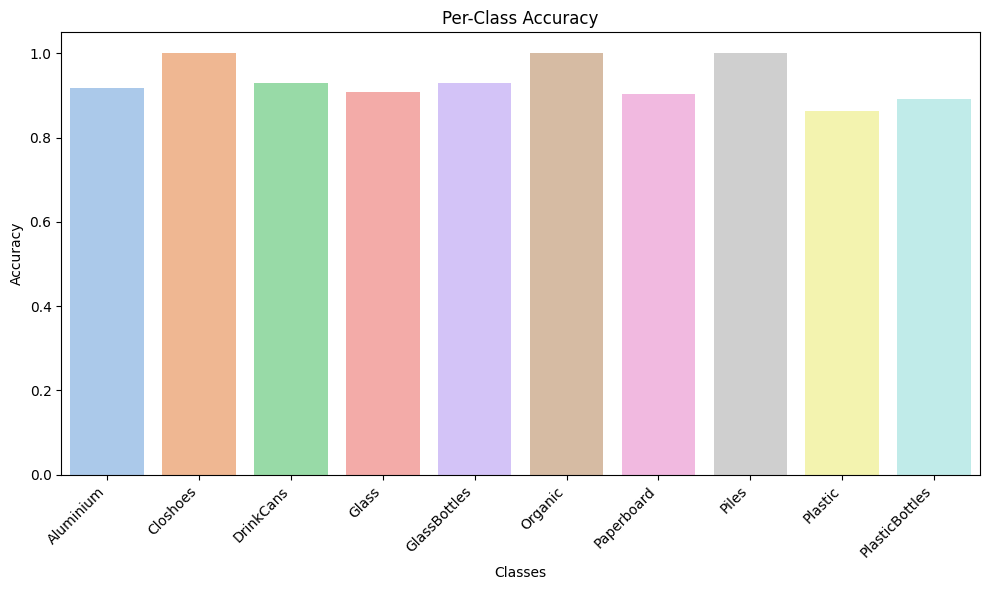

In [21]:
# prompt: make a histogram with seaborn with the classnames and the accuracy for each one of them with slight bright colors

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Create a bar plot with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=class_accuracy, palette="pastel")
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()


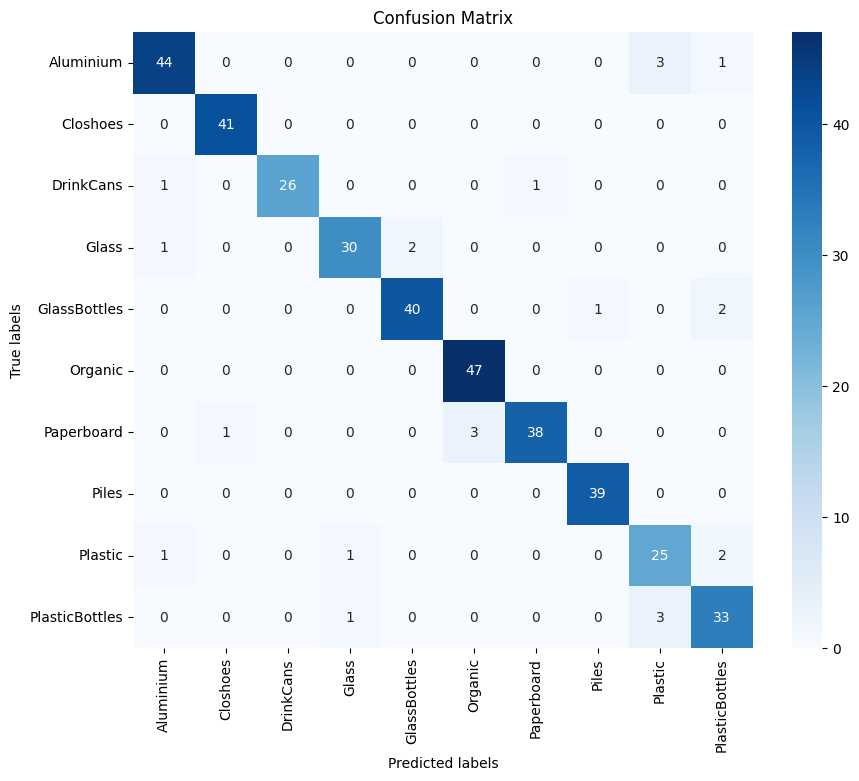

In [17]:
# prompt: show confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# prompt: load model v9 from drive and use set/test from drive to compiute overall accuracy on the predicion

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np

# Load the model
model_path = '/content/model_v9.h5'  # Update with your actual path
loaded_model = load_model(model_path)


In [ ]:
!unzip -q /content/test.zip

In [ ]:

# Load test dataset from Drive
test_ds = image_dataset_from_directory(
  '/content/test', # Update with your actual path
  labels = "inferred",
  label_mode = "categorical",
  seed=123,
  image_size=(254, 254),
  batch_size=128,
  shuffle=False
)

# Predict on test set
predictions = loaded_model.predict(test_ds)

# Get true labels
y_true = []
for images, labels in test_ds:
  y_true.extend(np.argmax(labels, axis=1))

# Get predicted labels
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy
correct = np.sum(y_pred == y_true)
accuracy = correct / len(y_true)
print(f"Overall Accuracy on Test Set: {accuracy * 100:.2f}%")

Found 307 files belonging to 8 classes.


KeyboardInterrupt: 

Found 307 files belonging to 8 classes.


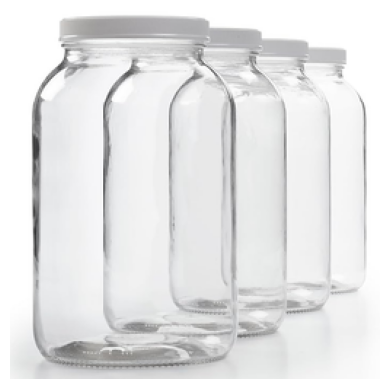

1/1 [==============================] - 1s 566ms/step
Predicted Class: Glass
Aluminium: 0.0000
DrinkCans: 0.0000
Glass: 0.9930
GlassBottles: 0.0070
Organic: 0.0000
Paperboard: 0.0000
Plastic: 0.0000
PlasticBottles: 0.0000


In [ ]:
# prompt: take a picture from content/test, show it, make a prediction and show the list of scores

import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

test_ds = image_dataset_from_directory(
  '/content/test', # Update with your actual path
  labels = "inferred",
  label_mode = "categorical",
  seed=123,
  image_size=(254, 254),
  batch_size=128,
  shuffle=False
)

# Load the image
img_path = '/content/test/Glass/Glass_319.jpg' # Replace with the actual path to your image
img = image.load_img(img_path, target_size=(254, 254))
class_names = test_ds.class_names
# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
#img_array /= 255.0  # Normalize pixel values

# Make a prediction
prediction = loaded_model.predict(img_array)

# Get predicted class
predicted_class_index = np.argmax(prediction)
predicted_class = class_names[predicted_class_index]
print("Predicted Class:", predicted_class)

# Show prediction scores for all classes
for i, score in enumerate(prediction[0]):
    print(f"{class_names[i]}: {score:.4f}")


In [ ]:
# prompt: make a prediction on a picture of each class of test_ds until it is correct and show the list of score for each one of them

import numpy as np
from tensorflow.keras.preprocessing import image

# Assuming 'test_ds' and 'class_names' are defined as in your provided code
class_names = test_ds.class_names
# Iterate over each class
for class_index in range(len(class_names)):
    print(f"Looking for a correct prediction for class: {class_names[class_index]}")

    # Iterate over images in the test dataset
    for i, (images, labels) in enumerate(test_ds):
        # Find an image of the current class
        true_label = np.argmax(labels, axis=1)
        if class_index in true_label:
            index_in_batch = np.where(true_label == class_index)[0][0]
            img = images[index_in_batch]

            # Preprocess the image
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            #img_array /= 255.0  # Assuming your model expects input in range [0, 1]

            # Make prediction
            prediction = loaded_model.predict(img_array)
            predicted_class = np.argmax(prediction)

            # Print prediction and scores
            print(f"  Image {i * 128 + index_in_batch}: Predicted: {class_names[predicted_class]}, True: {class_names[class_index]}, Scores: {prediction[0]}")

            # If prediction is correct, move to the next class
            if predicted_class == class_index:
                break


Looking for a correct prediction for class: Aluminium
1/1 [==============================] - 1s 1s/step
  Image 0: Predicted: Aluminium, True: Aluminium, Scores: [9.9944288e-01 6.8631368e-07 9.0565118e-06 5.0344399e-11 1.6009104e-05
 5.2427745e-04 6.9933726e-06 9.2206228e-08]
Looking for a correct prediction for class: DrinkCans
1/1 [==============================] - 0s 186ms/step
  Image 48: Predicted: DrinkCans, True: DrinkCans, Scores: [4.7457847e-04 9.9854976e-01 3.7567816e-06 3.7014193e-05 2.8552354e-06
 3.4201807e-06 8.5737370e-04 7.1182658e-05]
Looking for a correct prediction for class: Glass
1/1 [==============================] - 0s 175ms/step
  Image 76: Predicted: Plastic, True: Glass, Scores: [1.1503172e-01 7.0453907e-04 1.3540690e-01 8.8510569e-06 1.0790319e-05
 1.5303176e-05 7.4826771e-01 5.5410556e-04]
Looking for a correct prediction for class: GlassBottles
1/1 [==============================] - 0s 296ms/step
  Image 109: Predicted: GlassBottles, True: GlassBottles, Sco